# Managing 2013 Data

I want to first look at titles from both subreddits from the year 2013. There are a few things that I had to adjust before modeling and interpreting my data.

1. For every year of each subreddit, `mildlyinteresting` has a multitude of more posts than `mildlyinfuriating`. That results in unbalanced classes when I model. My solution to that is: I will use all of my 2013 data collected from `mildlyinfuriating` but I will keep track of how many files there are (each file consists of 1000 posts - see [scrape.py](./scrape.py)). I will then randomly sample that many files from all of files I have from `mildlyinteresting` of that same year. This ensures that I have balanced classes when I model.
2. From my EDA, I've seen that the words `interesting` and `infuriating` were some of the most impactful words (both were the 2nd highest respectively). I will include them amongst my `stop_words`. Also, I noticed at least two words who's base and adverb were among the top 15 strongest words. Because of that, I planned to lemmatize my corpus (see cell [class LemToken()](#lem_token), since doing so will provide me with more accurate results. However, I realized that its very computationally expensive, and since it most likely won't interfere with my top results, I can skip this step.

## Setup:
1. Bring in all needed 2013 JSON data from both subreddits. I will use this as train data. As well as bring in the first 1000 posts of both subreddit from 2014. I will use this as test data.
2. I will model this data in a number of ways and tune them to get the best results.
3. Visualize certain features. I will usually look at the strongest words, and if there's a high score, I will also compare true to predicted.
4. Address **Task 1**

In [1]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk import word_tokenize
from sklearn import metrics
from glob import glob
import pandas as pd
import numpy as np
import regex as r
import random
import pickle
import json

%matplotlib inline

## Step 1

In [2]:
# I know that I only have 15 mildlyinfuriating files for 2013
filenames = random.sample(glob('../data/mildlyinteresting/2013/*.json'), 15)

In [3]:
all_train = []
for f_name in random.sample(glob('../data/mildlyinteresting/2013/*.json'), 15):
    with open(str(f_name)) as f:
        all_train += json.load(f)['data']
for f_name in glob('../data/mildlyinfuriating/2013/*.json'):
    with open(str(f_name)) as f:
        all_train += json.load(f)['data']

In [4]:
all_test = []
with open('../data/mildlyinteresting/2014/data_1388716722.json') as f:
    all_test += json.load(f)['data']
with open('../data/mildlyinfuriating/2014/data_1388686520.json') as f:
    all_test += json.load(f)['data']

In [5]:
df_train = pd.DataFrame(data=all_train, columns=['title','subreddit'])
df_test = pd.DataFrame(data=all_test, columns=['title','subreddit'])

In [6]:
df_train.drop_duplicates(inplace=True)
df_test.drop_duplicates(inplace=True)

In [47]:
df_train.to_csv('../assets/train_2013', sep='\t', encoding='utf-8')
df_test.to_csv('../assets/test_2013', sep='\t', encoding='utf-8')

<a href="#lem_token"></a>
`class LemToken(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, title):
        return [self.wnl.lemmatize(t) for t in word_tokenize(title)]`

In [7]:
X_train = df_train['title']
y_train = pd.get_dummies(df_train['subreddit'],drop_first=True)
X_test = df_test['title']
y_test = pd.get_dummies(df_test['subreddit'],drop_first=True)
subreddits = ['mildlyinteresting','mildlyinfuriating']

**Making sure my classes are balanced:**

In [8]:
y_train.sum()/y_train.shape[0]

mildlyinteresting    0.504692
dtype: float64

In [9]:
sw = stopwords.words('english') + ['interesting','infuriating','fuck', 'looked']

**'fuck' and 'look' have been dropped since I couldn't lemmatize due to computational reasons, and they are in the top 5. Also, my following `TfidfVectorizer` and `LogisticRegression` have been previously optimized using GridSearchCV.**

In [10]:
tfidf = TfidfVectorizer(
                        min_df=1,
                        max_df=1.0,
                        stop_words=sw,
                        analyzer='word',
                        max_features=800,
                        token_pattern=r'\w{1,}',
                        strip_accents='unicode')

In [11]:
train_tf = tfidf.fit_transform(X_train,y_train)
test_tf = tfidf.transform(X_test)

## Step 2

In [12]:
lr = LogisticRegression(C=.999, max_iter=100, solver='saga', random_state=42)

In [13]:
lr.fit(train_tf, y_train.values.ravel())
y_pred = lr.predict(test_tf)
y_pred_prob = lr.predict_proba(test_tf)[:, 1]

In [14]:
print('Train data score: {} \nTest data score: {}'.format(lr.score(train_tf,y_train),lr.score(test_tf,y_test)))

Train data score: 0.7510879912960696 
Test data score: 0.7344461305007587


In [120]:
acc_lr = metrics.accuracy_score(y_test.values.ravel(),y_pred)
acc_lr

0.7344461305007587

In [143]:
with open('../assets/lr_tuned_pipe.pkl', 'wb+') as f:
    pickle.dump(lr, f)

** This is good to see. My model isn't overfit to the train data.**

In [129]:
coefs_df_1 = pd.DataFrame({"Feature":tfidf.get_feature_names(),"Weight":lr.coef_[0],"Positive":lr.coef_[0] > 0})
# 'Positive' here refers to the numeric value. 

In [141]:
coefs_df_1.sort_values('Weight',ascending=False).head()

,Feature,Weight,Positive
395,looks,5.531726,True
255,found,4.954312,True
721,tree,3.129480,True
705,til,3.007747,True
588,saw,2.829142,True


In [131]:
coefs_df_1.sort_values('Weight').head()

,Feature,Weight,Positive
266,fucking,-4.323702,False
612,shit,-4.032756,False
312,hate,-3.585054,False
181,damn,-3.565467,False
220,every,-3.176798,False


In [133]:
def bar_plot_features(coefs_df, post_weight, neg_weight,xt_1, xt_2, axh):
    a = coefs_df[(coefs_df['Weight'] >= post_weight) | (coefs_df['Weight'] <= neg_weight)].sort_values('Weight')['Weight']
    b = coefs_df[(coefs_df['Weight'] >= post_weight) | (coefs_df['Weight'] <= neg_weight)].sort_values('Weight')['Feature']

    N = len(a)
    ind = np.arange(N)
    width= .5

    plt.barh(ind, a, width) #, color=coefs_df['Positive'].map({True: 'orange', False: 'purple'})
                            # doing this somehow still displays wrong colors.

    plt.xlabel('Word Strength',fontsize=20)
    plt.title('Strongest Words for Infuritation & Interest',fontsize=35)
    plt.yticks(ind, b,fontsize=20, rotation=0)

    plt.xticks(np.arange(xt_1, xt_2, .5),fontsize=11)

    plt.axvline(x=0.0, c='black')
    plt.axhline(y=axh, c='black', linestyle='--')

    a = plt.gcf()
    a.set_size_inches(17, 9)

    plt.show()

## Step 3

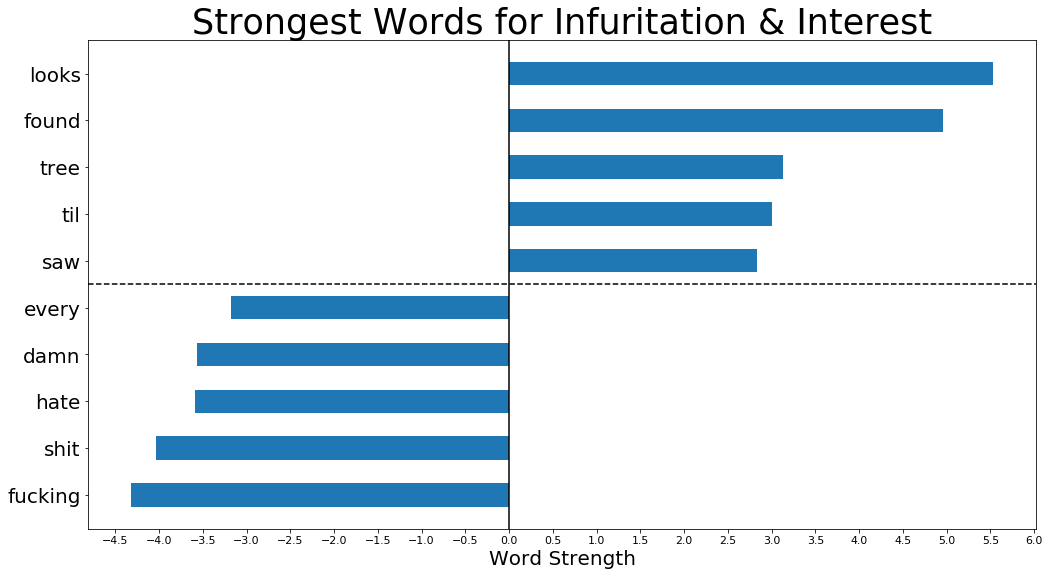

In [138]:
bar_plot_features(coefs_df_1, 2.82914, -3.126718, -4.5, 6.5, 4.5)

**It's nice to always be able to visualize how impactful these words are in respect to one another. For example, in regrads to the `infuriating` words, they all gradually get more strength, but when it comes to `interesting`, there's a huge jump from "tree" to "found" and "looks".**

## Step 2 (finding better models)
### I will now try a number of models, and tune as I go.

In [20]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier

I want to see how well these models preform and compare their scores. These are the scores I'll focus on:
1. Model Score: default scoring metric of each model.
2. Accuracy: proportion of correctly labeled predictions $\frac{TP+TN}{n}$
3. Precision: correct positive predictions $\frac{TP}{TP+FP}$
4. F1: weighted average between recall (sensitivity) and precision $2 \cdot \frac{(Recall \cdot Precision)}{(Recall + Precision)}$

In [21]:
stats_df = pd.DataFrame(index=['cv','train_score', 'test_score','accuracy','precision','f1_test'])

In [42]:
models = [
    ('KNeighborsClassifier',KNeighborsClassifier()),
    ('DecisionTreeClassifier',DecisionTreeClassifier(random_state=3)),
    ('BaggingClassifier',BaggingClassifier(random_state=3,n_jobs=3)),
    ('RandomForestClassifier',RandomForestClassifier(random_state=3,n_jobs=3)),
    ('AdaBoostClassifier',AdaBoostClassifier(random_state=3)),
    ('GradientBoostingClassifier',GradientBoostingClassifier(random_state=3))
]

In [23]:
for x in models:
    model = Pipeline([x])
    cv_score = cross_val_score(model,train_tf,y_train.values.ravel(),cv=5).mean()
    model.fit(train_tf,y_train.values.ravel());
    train_score = model.score(train_tf,y_train.values.ravel())
    test_score = model.score(test_tf,y_test.values.ravel())
    acc_score = metrics.accuracy_score(y_test,model.predict(test_tf))
    prec_score = metrics.precision_score(y_test,model.predict(test_tf))
    f1_score = metrics.f1_score(y_test,model.predict(test_tf))
    stats_df[x[0]] = [cv_score,train_score,test_score,acc_score,prec_score,f1_score]
    with open('../assets/'+x[0]+'_simple.pkl', 'wb+') as f:
        pickle.dump(model, f)
    print(stats_df[x[0]])

cv             0.651060
train_score    0.764280
test_score     0.656045
accuracy       0.656045
precision      0.686391
f1_test        0.630435
Name: KNeighborsRegressor, dtype: float64
cv             0.688733
train_score    0.918741
test_score     0.699039
accuracy       0.699039
precision      0.728311
f1_test        0.681988
Name: DecisionTreeRegressor, dtype: float64
cv             0.708826
train_score    0.904665
test_score     0.708144
accuracy       0.708144
precision      0.729670
f1_test        0.697113
Name: BaggingRegressor, dtype: float64
cv             0.708724
train_score    0.908099
test_score     0.700556
accuracy       0.700556
precision      0.728717
f1_test        0.684435
Name: RandomForestRegressor, dtype: float64
cv             0.650959
train_score    0.655379
test_score     0.645928
accuracy       0.645928
precision      0.832957
f1_test        0.513213
Name: AdaBoostRegressor, dtype: float64
cv             0.665442
train_score    0.678635
test_score     0.667172

In [45]:
model_list = ['','KNN','DCT','BAG','RMF','ADB','GBC']
model_list_long = ['KNeighborsClassifier','DecisionTreeClassifier','BaggingClassifier','RandomForestClassifier','AdaBoostClassifier','GradientBoostingClassifier']

In [46]:
stats_df.T.columns = model_list_long
stats_df.T

,cv,train_score,test_score,accuracy,precision,f1_test
KNeighborsRegressor,0.651060,0.764280,0.656045,0.656045,0.686391,0.630435
DecisionTreeRegressor,0.688733,0.918741,0.699039,0.699039,0.728311,0.681988
BaggingRegressor,0.708826,0.904665,0.708144,0.708144,0.729670,0.697113
RandomForestRegressor,0.708724,0.908099,0.700556,0.700556,0.728717,0.684435
AdaBoostRegressor,0.650959,0.655379,0.645928,0.645928,0.832957,0.513213
GradientBoostingClassifier,0.665442,0.678635,0.667172,0.667172,0.832347,0.561917


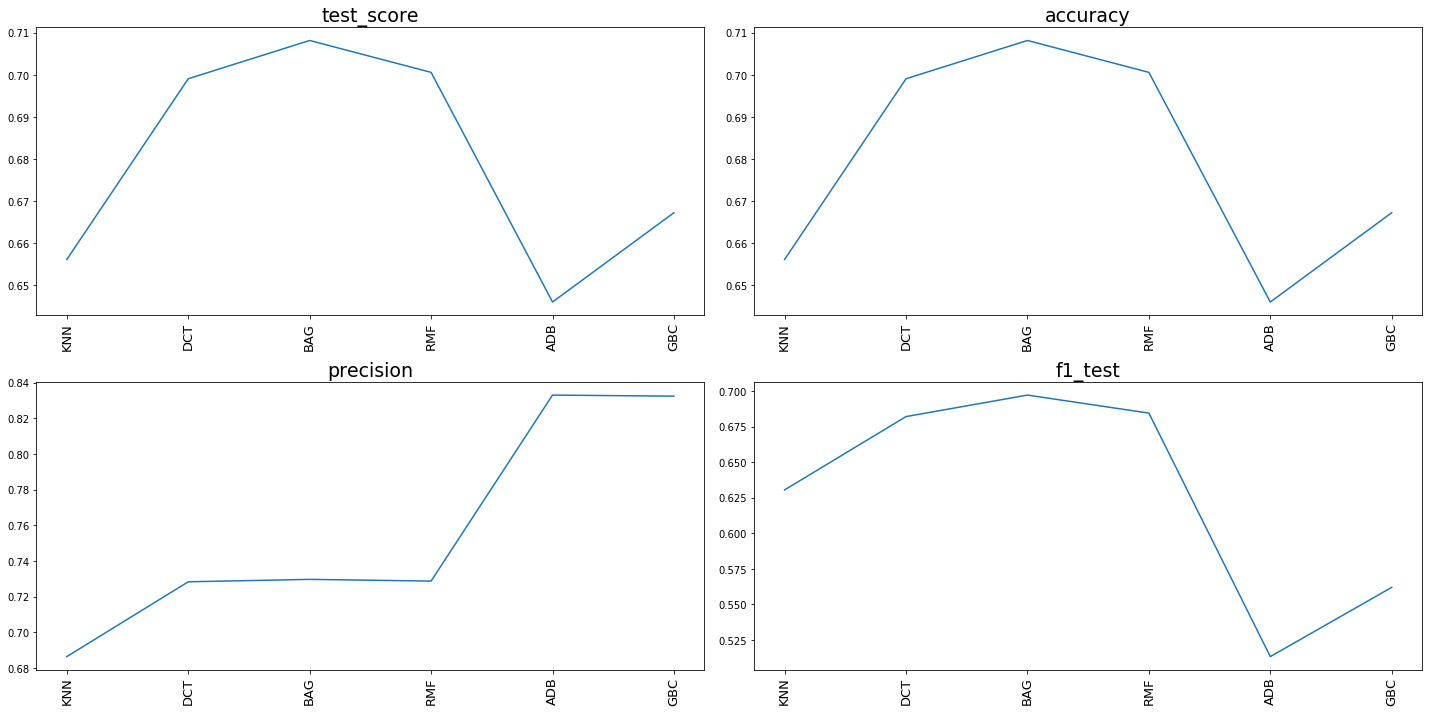

In [26]:
f,axes = plt.subplots(2,2,figsize=(20,10))
for ax,score in zip(axes.flatten(),stats_df.index[2:]):
    stats_df.T[score].plot(kind='line',ax=ax);
    ax.set_title(score, fontsize=19)
    ax.set_xticklabels(model_list, rotation=90, fontsize=13)
    plt.tight_layout()

**Accuracy** is the metric I want to aim for. This is because accuracy is the proportion of correctly labeled predictions. It's not 'better' or 'worse' if I have false positives or false negatives when classifying whether a post's title is from `mildlyinteresting` or `mildyinfuriating`. It's equally 'bad', and I want to simply ensure that my model correctly identifies the subreddit as much as possible. I do not care about 'being cautious', I simply want to be as accurate as possible.

Because of that, it seems like `BaggingClassifier` will be  the best metric. However, I'll briefly attempt to tune both `AdaBoost` and `GradientBoost` since they both excel at precision, and also `RandomForest` just to get an idea of how it will preform when tuned.

In [28]:
ada = AdaBoostClassifier(random_state=3)
ada_params = {
    'n_estimators': [70, 170],
    'learning_rate': [.8,.98,1.0]
}
gs_ada = GridSearchCV(ada,param_grid=ada_params,cv=3,verbose=1,n_jobs=3)
gs_ada.fit(train_tf,y_train.values.ravel())
gs_ada.best_score_

with open('../assets/ada_tuned_pipe.pkl', 'wb+') as f:
    pickle.dump(gs_ada, f)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:   26.6s finished


In [50]:
gs_ada.best_params_

{'learning_rate': 0.98, 'n_estimators': 170}

In [49]:
acc_ada = metrics.accuracy_score(y_test.values.ravel(),gs_ada.best_estimator_.predict(test_tf))
acc_ada

0.6813353566009105

In [34]:
gbc = GradientBoostingClassifier(random_state=3)
gbc_params = {
    'n_estimators': [110,155,50],
    'learning_rate': [.1,.05]
}
gs_gbc = GridSearchCV(gbc,param_grid=gbc_params,cv=3,verbose=0,n_jobs=3)
gs_gbc.fit(train_tf,y_train.values.ravel())
gs_gbc.best_score_

with open('../assets/gbc_tuned_pipe.pkl', 'wb+') as f:
    pickle.dump(gs_gbc, f)

In [51]:
gs_gbc.best_params_

{'learning_rate': 0.1, 'n_estimators': 155}

In [58]:
acc_gbc = metrics.accuracy_score(y_test.values.ravel(),gs_gbc.best_estimator_.predict(test_tf))
acc_gbc

0.6808295397066262

In [32]:
rmf = RandomForestClassifier(random_state=42,n_jobs=3)

rmf_params = {
    'n_estimators': [10,155],
    'max_depth':[1,10,100]
}
gs_rmf = GridSearchCV(rmf,param_grid=rmf_params,cv=3,verbose=1,n_jobs=3)
gs_rmf.fit(train_tf,y_train.values.ravel())
gs_rmf.best_score_

with open('../assets/rmf_tuned_pipe.pkl', 'wb+') as f:
    pickle.dump(gs_rmf, f)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:   19.7s finished


In [52]:
gs_rmf.best_params_

{'max_depth': 100, 'n_estimators': 155}

In [53]:
acc_rmf = metrics.accuracy_score(y_test.values.ravel(),gs_rmf.best_estimator_.predict(test_tf))
acc_rmf

0.6985331310065757

In [40]:
bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=3),random_state=3,n_jobs=3)
bag_params = {
    'n_estimators': [100, 30, 170]
}
gs_bag = GridSearchCV(bag,param_grid=bag_params,cv=3,verbose=1)
gs_bag.fit(train_tf,y_train.values.ravel())
gs_bag.best_score_

with open('../assets/bag_2013_tuned_pipe.pkl', 'wb+') as f:
    pickle.dump(gs_bag, f)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 12.8min finished


In [54]:
gs_bag.best_params_

{'n_estimators': 100}

In [55]:
acc_bag = metrics.accuracy_score(y_test.values.ravel(),gs_bag.best_estimator_.predict(test_tf))
acc_bag

0.7197774405665149

# Step 3

In [121]:
tuned_models = ['LR','ADA','GDB','RMF','BAG']

In [122]:
tuned_model_scores = [acc_lr,acc_ada,acc_gbc,acc_rmf,acc_bag]

In [123]:
tuned_stats_df = pd.DataFrame(index=['Score'],columns=tuned_models)
for model,score in zip(tuned_models,tuned_model_scores):
    tuned_stats_df[model] = score

In [124]:
tuned_stats_df

,LR,ADA,GDB,RMF,BAG
Score,0.734446,0.681335,0.68083,0.698533,0.719777


As thought, (aside from `LogisitcRegression`) it's clear that the `BaggingClassifier` is by far the best, since it scores the highest on accuracy. Although, despite tuning, there was little gain in the score. And also the fact that 72% isn't the best of scores. But that can also be due to the fact that, many of the weaker features are often found in both subreddits, and that, not every post has the top 5-25 features that hold a lot of weight.

But, knowing that, let's see which features hold the most weight after optimizing for accuracy. However, since `BaggingClassifier` doesn't show feature importances, I'll compare the weights from `LogisitcRegression` to `RandomForestClassifier` since it scored the 2nd best.

In [125]:
coefs_df_2 = pd.DataFrame({"Feature":tfidf.get_feature_names(),"Weight":gs_rmf.best_estimator_.feature_importances_})

In [126]:
coefs_df_2.sort_values('Weight',ascending=False).head()

,Feature,Weight
255,found,0.044783
395,looks,0.042699
378,like,0.022929
612,shit,0.019140
509,people,0.018700


In [127]:
coefs_df_2.sort_values('Weight').head()

,Feature,Weight
161,commercial,0.000052
125,ceiling,0.000053
107,butter,0.000060
658,star,0.000062
619,shower,0.000065


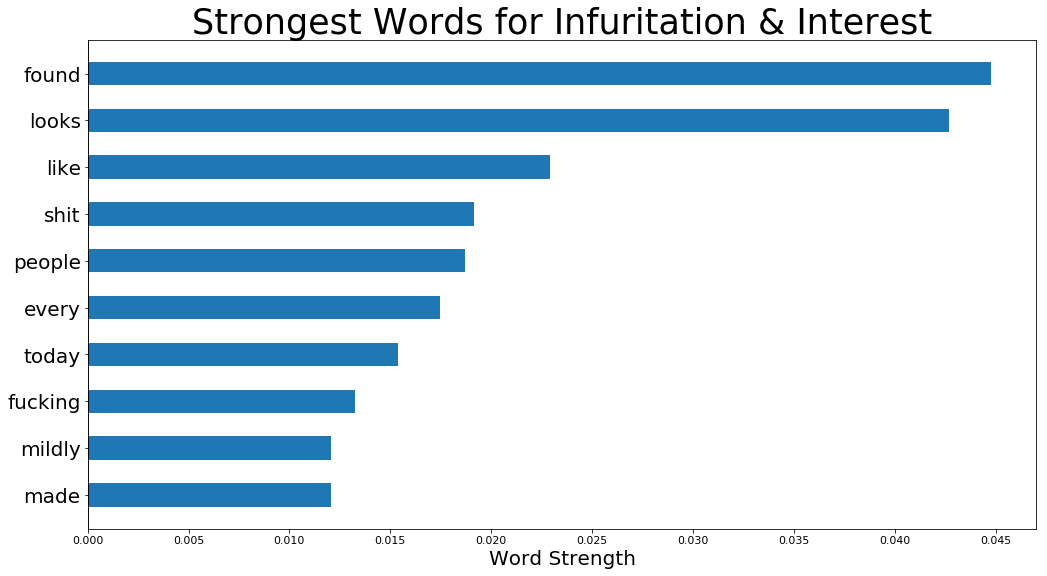

In [128]:
a = coefs_df_2[(coefs_df['Weight'] >= 0.012039)].sort_values('Weight')['Weight']
b = coefs_df_2[(coefs_df['Weight'] >= 0.012039)].sort_values('Weight')['Feature']

N = len(a)
ind = np.arange(N)
width= .5

plt.barh(ind, a, width)

plt.xlabel('Word Strength',fontsize=20)
plt.title('Strongest Words for Infuritation & Interest',fontsize=35)
plt.yticks(ind, b,fontsize=20, rotation=0)

plt.xticks(np.arange(0, .05, .005),fontsize=11)

plt.axvline(x=0.0, c='black')

a = plt.gcf()
a.set_size_inches(17, 9)

plt.show()

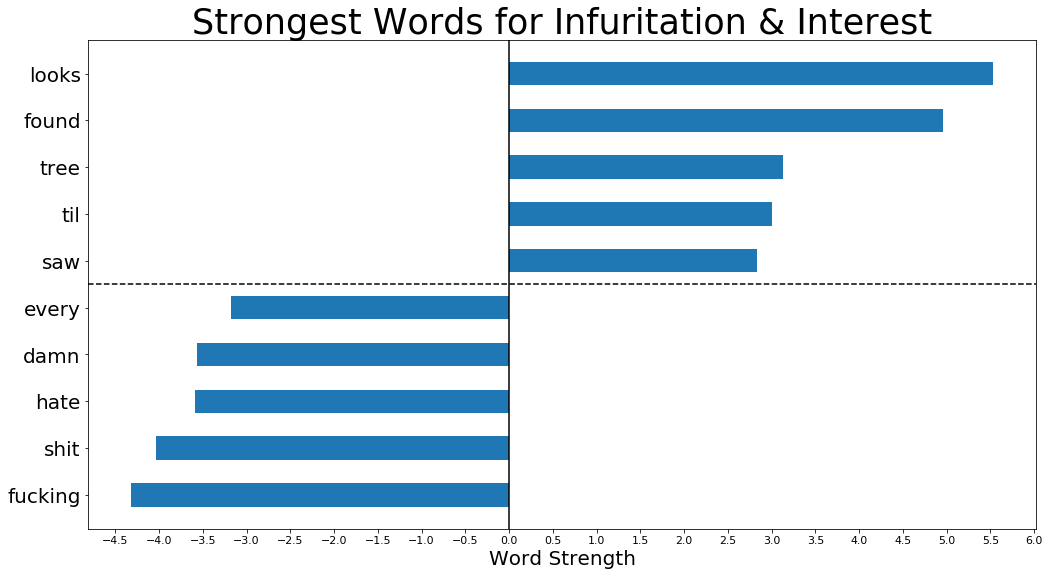

In [139]:
bar_plot_features(coefs_df_1, 2.82914, -3.126718, -4.5, 6.5, 4.5)

In [142]:
coefs_df_1.to_csv('../assets/coefs_lr_2013', sep='\t', encoding='utf-8')
coefs_df_2.to_csv('../assets/coefs_bag_2013', sep='\t', encoding='utf-8')

# Task 1
(from [Notebook 0](jn_0_gather_data_and_eda.ipynb))
## Thoughts and Conclusions

I'm very surprised that `LogisitcRegression` has a better accuracy score than a tuned `BaggingClassifier`. Not only that, but `LogisitcRegression` has much more understandable and usable feature importances than `RandomForest`. 

1. It's clear that `LogisitcRegression` scored better with nearly 73.5% whereas a tuned `BaggingClassifier` scored a max of around 72%. (Also realized that the latter model requires much more computation.)
2. `LogisitcRegression` clearly describes which features impact which subreddit, which is great. Although `RandomForest` doesn't do that, it can be inferred (with this data in specific) which impact what subreddit. It's also interesting to note that there are differences. Such as 'like', and 'mildly' ('made' is in the top 10 in LR).

### Goal:
I wanted to be able to use this data personally advertise on `mildlyinteresting` and trash talk my competitors on `mildlyinfuriating` and I think I have the results to do so. In 2013, I could promote my product by referring to it as something cool and new. Focusing on 'til' (today I learned), or 'found' or 'saw'. On the other hand, I demote my competitors, I can mention how much I 'hate' it, and how 'every' 'damn' time, it 'fucking' 'doesn't' work.